# Openpsychometrics Personality EDA

### Colab Setup

In [1]:
from google.colab import drive # import drive from google colab
from os.path import join  

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT, force_remount=True)           # we mount the google drive at /content/drive

MY_REPO_PATH = 'MyDrive/personality-in-fiction'
PROJECT_PATH = join(ROOT, MY_REPO_PATH)

%cd "{PROJECT_PATH}"

Mounted at /content/drive
/content/drive/MyDrive/personality-in-fiction


In [2]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
import scipy.stats as stats
import plotly
import plotly.express as px
import numpy as np
from scipy.stats import zscore
from sklearn.manifold import TSNE

%matplotlib inline
# plotly.offline.init_notebook_mode()

## Read Data

In [3]:
# The means of the ratings of each character for each trait
raw_df = pd.read_csv('data/op/character_means.csv', index_col=0)
# The standard deviations of the *ratings* before aggregation
# std_df = pd.read_csv('data/op/character_std.csv', index_col=0)
# # The number of observations for each trait for each character
# n_df = pd.read_csv('data/op/character_n.csv', index_col=0)

raw_df.head(3)

,BAP1,BAP2,BAP3,BAP4,BAP5,BAP6,BAP7,BAP8,BAP9,BAP10,BAP11,BAP12,BAP13,BAP14,BAP15,BAP16,BAP17,BAP18,BAP19,BAP20,BAP21,BAP22,BAP23,BAP24,BAP25,BAP26,BAP27,BAP28,BAP29,BAP30,BAP31,BAP32,BAP33,BAP34,BAP35,BAP36,BAP37,BAP38,BAP39,BAP40,...,BAP229,BAP230,BAP231,BAP232,BAP233,BAP234,BAP235,BAP236,BAP237,BAP238,BAP239,BAP240,BAP241,BAP242,BAP243,BAP244,BAP245,BAP246,BAP247,BAP248,BAP249,BAP250,BAP251,BAP252,BAP253,BAP254,BAP255,BAP256,BAP257,BAP258,BAP259,BAP260,BAP261,BAP262,BAP263,BAP264,BAP265,BAP266,BAP267,BAP268
NCIS/1,86.5,82.1,74.8,7.9,31.1,78.1,37.9,20.6,55.7,67.3,83.7,78.6,15.1,83.0,17.7,43.1,48.0,20.1,23.4,85.5,49.6,27.2,13.9,8.5,52.6,10.9,60.0,7.2,72.6,44.6,63.2,5.6,65.4,91.6,84.0,58.0,83.5,63.0,12.5,26.3,...,24.8,14.1,21.7,25.5,15.1,88.3,54.7,37.9,44.8,51.5,81.1,30.3,44.8,35.4,80.8,65.7,65.3,65.8,37.6,57.1,37.1,19.6,32.6,24.3,47.8,41.5,51.5,61.6,61.8,38.5,38.4,57.9,21.1,64.2,23.4,29.4,76.7,32.8,81.9,11.5
NCIS/2,18.5,88.2,24.3,14.4,13.1,40.4,69.7,73.3,48.7,55.0,79.0,46.7,70.9,51.0,68.6,47.5,24.5,64.6,19.6,74.0,58.3,31.2,76.5,27.9,47.5,62.5,26.7,12.8,43.3,25.4,52.9,54.0,20.2,15.0,44.4,39.0,49.5,28.3,17.0,20.1,...,67.8,38.6,53.7,58.1,62.9,75.6,35.5,72.2,14.0,81.4,38.2,72.8,55.1,71.4,74.8,25.6,23.9,57.7,78.0,36.9,41.0,43.1,56.4,50.6,67.0,57.8,50.8,19.9,60.1,38.1,54.8,83.3,84.5,32.1,42.1,64.7,69.2,34.3,70.4,34.3
NCIS/3,16.0,86.3,11.9,64.8,35.9,61.5,15.5,70.2,60.2,22.8,55.1,68.6,90.4,62.2,67.0,86.1,66.1,55.6,30.5,36.8,67.2,61.3,78.1,29.4,27.9,22.4,35.1,6.8,8.7,11.6,79.0,9.6,45.1,9.0,52.9,45.7,91.2,74.3,15.4,17.6,...,78.9,28.5,17.8,19.0,67.5,92.0,30.4,81.4,33.7,85.1,72.7,18.4,78.6,71.8,93.9,91.0,15.9,24.2,37.1,54.1,35.6,42.9,42.4,91.0,63.8,40.8,14.9,22.6,27.8,52.7,18.9,75.2,93.7,49.6,36.0,31.5,22.3,15.9,78.8,13.2


In [4]:
names_df = pd.read_csv('data/op/character_map.csv', names=['code', 'work','character'], index_col=0, skiprows=1)
names_df.head(3)

,work,character
code,,
NCIS/1,NCIS,Leroy Jethro Gibbs
NCIS/2,NCIS,Anthony DiNozzo
NCIS/3,NCIS,Abby Sciuto


In [5]:
# A map of the trait codes to the bipolar adjective pairings, as well as hand-labeled HEXACO classification
trait_df = pd.read_csv('data/op/trait_map.csv', index_col=0)
trait_df['adjectives'] = trait_df[['Left', 'Right']].values.tolist()
trait_df.drop(['Left', 'Right'], axis=1, inplace=True)
trait_df.head(3)

,Hexaco,Hexaco Relationship,Confident?,adjectives
Trait,,,,
BAP1,O,-,NaN,"[playful, serious]"
BAP2,X,+,NaN,"[shy, bold]"
BAP3,E,+,NaN,"[cheery, sorrowful]"


Dictionary for use in making traits readable

In [6]:
trait_dict = trait_df['adjectives'].to_dict()
for k, v in trait_dict.items():
    trait_dict[k] = str(v)
# View a slice
dict(list(trait_dict.items())[0:2])

{'BAP1': "['playful', 'serious']", 'BAP2': "['shy', 'bold']"}

## Correlated traits

In [7]:
c = raw_df.corr()
c.index = c.index.map(trait_dict)
c.columns = c.columns.map(trait_dict)

# Display the 15 most positively correlated pairs
c.unstack().sort_values()[-len(c)-30:-len(c)][::2]

['bossy', 'meek']               ['dominant', 'submissive']         0.922024
['soulless', 'soulful']         ['cruel', 'kind']                  0.923467
['scandalous', 'proper']        ['mischievous', 'well behaved']    0.925968
['vain', 'demure']              ['arrogant', 'humble']             0.927526
['assertive', 'passive']        ['bossy', 'meek']                  0.928337
['workaholic', 'slacker']       ['diligent', 'lazy']               0.928780
['proletariat', 'bourgeoisie']  ['blue-collar', 'ivory-tower']     0.929082
['trash', 'treasure']           ['💩', '🌟']                         0.931288
['angelic', 'demonic']          ['wholesome', 'salacious']         0.932100
['poisonous', 'nurturing']      ['cruel', 'kind']                  0.946431
['quarrelsome', 'warm']         ['bitter', 'sweet']                0.947924
['beautiful', 'ugly']           ['attractive', 'repulsive']        0.950649
['dominant', 'submissive']      ['assertive', 'passive']           0.950725
            

In [8]:
# Display the 15 most negatively correlated pairs
c.unstack().sort_values()[0:30][::2]

['😈', '😇']                     ['angelic', 'demonic']                -0.953692
['poisonous', 'nurturing']     ['angelic', 'demonic']                -0.950520
['high IQ', 'low IQ']          ['dunce', 'genius']                   -0.949836
['angelic', 'demonic']         ['cruel', 'kind']                     -0.947013
['cheery', 'sorrowful']        ['sad', 'happy']                      -0.935528
['quarrelsome', 'warm']        ['complimentary', 'insulting']        -0.933172
['luddite', 'technophile']     ['high-tech', 'low-tech']             -0.932522
['bitter', 'sweet']            ['warm', 'cold']                      -0.932136
['debased', 'pure']            ['angelic', 'demonic']                -0.930442
['💪', '\U0001f9e0']            ['intellectual', 'physical']          -0.928416
['wholesome', 'salacious']     ['debased', 'pure']                   -0.925306
                               ['poisonous', 'nurturing']            -0.925063
['😈', '😇']                     ['wholesome', 'salaci

The pairwise correlations of traits attest to the quality of the dataset, a simple measure of intra- and inter-rater reliability. Most of the relationships are very intuitive and aligned with traits we would expect to be related (albeit, some of them redundant).

## Preprocessing

Drop columns per my subjective assessment

In [9]:
emoji_cols = ["BAP235", "BAP236", "BAP237", "BAP238", "BAP239", "BAP240", "BAP241", "BAP242", "BAP243", "BAP244", "BAP245", "BAP246", "BAP247", "BAP248", "BAP249", "BAP250", "BAP251", "BAP252", "BAP253", "BAP254", "BAP255", "BAP256", "BAP257", "BAP258", "BAP259", "BAP260", "BAP261", "BAP262", "BAP263", "BAP264", "BAP265", "BAP266"]
raw_df.drop(emoji_cols, axis=1, inplace=True)
# Drop "orange vs purple", because why?
raw_df.drop('BAP68', axis=1, inplace=True)

Drop duplicate of BAP98 with fewer observations

In [10]:
raw_df.drop('BAP183', axis=1, inplace=True)

Drop columns *and* rows based on low interobserver agreement, or small sample size

In [11]:
# drop_rows = []
# for row in n_df.iterrows():
#     if np.mean(row[1:]) < 90:
#         raw_df.drop(row[0], inplace=True)
#         std_df.drop(row[0], inplace=True)
#         n_df.drop(row[0], inplace=True)
#         drop_rows.append(row[0])

        
# for row in std_df.iterrows():
#     if np.mean(row[1:]) > 30:
#         raw_df.drop(row[0], inplace=True)
#         std_df.drop(row[0], inplace=True)
#         n_df.drop(row[0], inplace=True)

In [12]:
# drop_cols = []
# for col in n_df.columns:
#     if np.mean(n_df[col]) < 30:
#         raw_df.drop(col, axis=1, inplace=True)
#         std_df.drop(col, axis=1, inplace=True)
#         n_df.drop(col, axis=1, inplace=True)
        
# for col in std_df.columns:
#     if np.mean(std_df[col]) > 25:
#         drop_cols.append(col)
#         raw_df.drop(col, axis=1, inplace=True)
#         std_df.drop(col, axis=1, inplace=True)
#         n_df.drop(col, axis=1, inplace=True)

Remove highly correlated attributes. When attributes more correlated than threshold, keep the one with the highest variance.

In [13]:
def drop_by_correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (np.abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                var_i = np.var(dataset[corr_matrix.columns[i]])
                var_j = np.var(dataset[corr_matrix.columns[j]])
                if var_i >= var_j:
                    colname = corr_matrix.columns[j]
                else:
                    colname = corr_matrix.columns[i]
                col_corr.add(colname)
    dataset = dataset.drop(col_corr, axis=1) # deleting the column from the dataset

    return dataset

In [14]:
raw_df.shape

(800, 234)

In [15]:
raw_df = drop_by_correlation(raw_df, .8)

In [16]:
raw_df.shape

(800, 116)

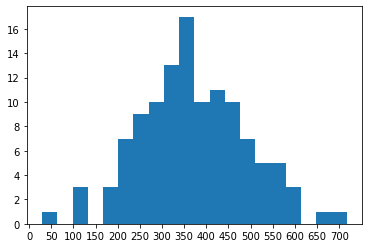

In [17]:
var = raw_df.var().sort_values()
plt.hist(x=var, bins=20)
plt.xticks(range(0,750,50))
plt.show()

In [18]:
var[var < 150]

BAP140     29.585119
BAP53     112.989336
BAP48     128.353450
BAP210    130.516516
dtype: float64

In [19]:
var[var < 150].index.map(trait_dict)

Index(['["right-brained'", "left-brained'"]', '['empirical', 'theoretical']',
       '['libertarian', 'socialist']', '['western', 'eastern']'],
      dtype='object')

The above features have variances substantially lower than the others. In particular, they seem to be abstract features that would not typically be used to describe personality. Or, in the case of "right-brained v. left-brained", users mostly left the slider at 50%, possibly due to a lack of understanding of the terms.

Therefore, we will drop these 4 columns.

In [20]:
raw_df = raw_df.drop(var[var < 150].index, axis=1)
raw_df.shape

(800, 112)

## Known Shows (for me)
This is just for me, for easy visualization/subjective analysis

In [21]:
known_shows = ['LK', 'WW', 'GP', 'LW', 'HP', 'CRA', 'PR', 'S', 'CBP', 'FS', 'FC', 'FG', 'F', 'R', 'SW', 'SV', 'ALA', 'SB', 'CAS', 'TS', 'TO', 'AD', 'GOT', 'LOTR']
known_shows = [x + '/' for x in known_shows]
known_chars = ['JP/3', 'H/1', 'RLA/1', 'SL/1', 'SF/1', 'TP/1', 'A/2', 'MCU/1', 'MCU/6', 'MCU/9', 'MCU/13']
known_shows
for char in raw_df.index:
    for show in known_shows:
        if char[0:len(show)] == show:
            known_chars.append(char)
known_chars[0:8]

['JP/3', 'H/1', 'RLA/1', 'SL/1', 'SF/1', 'TP/1', 'A/2', 'MCU/1']

## PCA

Center the traits on 0, but without unit variance

In [22]:
zero_mean_df = raw_df.apply(lambda x: x-np.mean(x))

<BarContainer object of 112 artists>

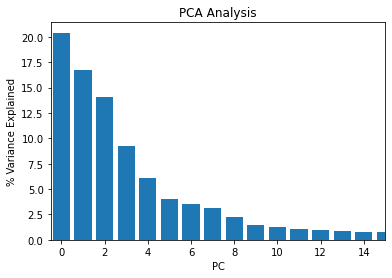

In [23]:
pca = PCA(n_components = len(zero_mean_df.columns))
principal_components = pca.fit_transform(zero_mean_df)
variance = pca.explained_variance_ratio_
var = np.round(pca.explained_variance_ratio_, decimals=3)*100
plt.ylabel('% Variance Explained')
plt.xlabel('PC')
plt.title('PCA Analysis')
plt.xlim(-.5,15)
plt.style.context('seaborn-whitegrid')
plt.bar(x=range(0, len(var)), height=var)


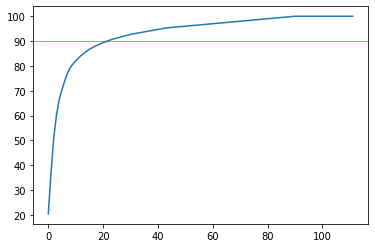

In [24]:
plt.plot(range(0,len(var)), np.cumsum(var))
plt.gca().axhline(y=90, color='red', linewidth=.5)

First 23 components explain 90% of the variance

In [25]:
np.cumsum(var)[22]

90.19999999999997

In [26]:
pca_df = pd.DataFrame(principal_components, index=raw_df.index)
pca_df['name'] = pca_df.index.map(names_df['character'].to_dict())
pca_df['work'] = pca_df.index.map(names_df['work'].to_dict())
pca_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,name,work
NCIS/1,-180.517202,-47.007272,29.119594,81.282151,-42.058726,9.880303,-8.312400,-20.272682,11.842962,18.827066,-22.390801,-6.572855,14.363601,22.383115,20.061511,5.163594,-22.607541,-1.164939,1.757792,-9.065735,1.524150,-7.929073,-5.011155,9.798103,8.822150,-0.240494,-20.289150,-3.068634,12.528492,4.392105,-13.141229,-16.980153,-2.208331,0.709699,-6.778555,5.312169,12.825622,2.596124,0.249609,-0.686485,...,2.022436,-2.671374,-6.996242,6.347834,-6.458983,-5.511157,-2.512154,-5.995623,1.930358,0.800885,-7.496190,-7.844875,-5.695979,-1.111377,9.760170,-3.302929,-0.385853,1.365124,-0.208961,-1.089517,-6.027975,-2.446224,-2.110108,-3.997793,6.312249,0.687981,4.797332,-2.538474,-6.974313,-0.738637,-1.530377,6.169319,-3.944696,1.920624,0.834628,-9.322793,-5.386537,-0.676499,Leroy Jethro Gibbs,NCIS
NCIS/2,71.513419,-88.709858,-59.471852,-34.098896,-79.352102,-10.123693,-17.442126,45.701364,-34.800257,-24.460879,-18.359322,12.095851,5.971772,22.962656,0.079662,-12.902307,-14.807119,22.452454,-13.642744,-13.483511,-7.921526,-3.353929,-15.673512,17.677161,3.163784,14.921254,-6.705243,-10.766947,24.000157,0.723079,3.714899,-3.256634,-13.078996,4.078910,0.026490,0.702323,-5.733539,4.940907,0.039620,0.547832,...,-9.381334,5.720032,-1.082190,-0.541102,5.737719,0.680473,2.922193,-3.244784,-4.287060,-0.544705,-3.839446,2.707962,8.319783,6.710437,-1.512930,-1.463027,0.393057,-0.865698,-1.987810,-4.640316,7.261734,-0.766027,2.645797,6.181482,3.117153,-0.549001,4.468224,1.563045,-2.254496,-0.686899,1.610993,-4.874204,-1.258990,-6.957174,-0.471710,-2.954393,1.317655,-5.799153,Anthony DiNozzo,NCIS
NCIS/3,29.410582,-92.561473,-137.422987,-30.198976,83.118609,-0.036622,79.794080,40.811446,-12.367140,6.085261,8.578447,11.588403,31.486411,5.547227,-11.758650,10.871298,0.642918,31.880184,10.782184,10.334053,-12.765713,-4.325495,-8.685245,-6.291453,8.897761,0.367029,-39.540014,7.044768,-0.666791,2.025543,-9.615859,-7.859022,14.927186,-0.411304,-4.970434,-20.304208,1.206460,-18.821169,-13.954180,9.828967,...,-0.866713,11.230232,1.748310,-8.161694,4.375916,-3.414528,-2.666764,0.038633,-4.988306,-4.351298,0.939589,-2.996573,1.787227,2.211295,-0.622482,-1.977713,-0.303532,-3.059883,2.079832,2.341338,4.656874,-2.604478,2.132752,0.487316,6.080015,-2.768187,-1.839667,-10.263791,5.574223,-0.962544,0.095206,4.759953,6.184685,-5.305925,3.130492,0.313176,2.941653,-3.391742,Abby Sciuto,NCIS


In [27]:
first_23_df = pca_df.iloc[:,:-91]
first_23_df['name'] = pca_df['name']
first_23_df['work'] = pca_df['work']

In [28]:
px.scatter_3d(first_23_df, title='PCA on Zero Mean Data', x=0, y=1, z=2, hover_name='name', hover_data=['name','work'])

## TSNE for Dimensionality Reduction

Use first 23 principal components. After extensive grid search, this is the best I could do.

In [29]:
early_exaggeration=1.2
perplexity = 1.5
learning_rate = 77
tsne = TSNE(n_components=3, perplexity=perplexity, learning_rate=learning_rate, random_state=0, early_exaggeration=early_exaggeration, method='exact').fit_transform(first_23_df.iloc[:,:-2])
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2', 'tsne3'], index=names_df.index)
tsne_df['name'] = tsne_df.index.map(names_df['character'].to_dict())
tsne_df['work'] = tsne_df.index.map(names_df['work'].to_dict())
px.scatter_3d(tsne_df, x='tsne1', y='tsne2', z='tsne3', hover_name='name', hover_data=['name', 'work'])

## UMAP for dimensionality reduction

In [30]:
import umap.umap_ as umap;

In [31]:
n_neighbors = 15
a=2
b=.4
metric='correlation'

# for metric in ['correlation', 'cosine', 'euclidean']:
#     for a in [.5, 1.5, 2.5]:
#         for b in np.arange(.35, .55, .08):
#             for n_neighbors in range(16, 17, 8):
trans = umap.UMAP(n_neighbors=n_neighbors, a=a, b=b, random_state=0, n_components=3, metric=metric).fit_transform(first_23_df.iloc[:,:-2])
umap_df = pd.DataFrame(trans, index=names_df.index)
umap_df['name'] = umap_df.index.map(names_df['character'].to_dict())
umap_df['work'] = umap_df.index.map(names_df['work'].to_dict())
print(n_neighbors, a, b, metric)
px.scatter_3d(umap_df, x=0, y=1, z=2, hover_name='name', hover_data=['name', 'work']).show()
px.scatter_3d(umap_df.loc[known_chars], x=0, y=1, z=2, hover_name='name', hover_data=['name', 'work']).show()

15 2 0.4 correlation


In [32]:
trans = umap.UMAP(n_neighbors=5, a=1, b=.4, random_state=0, n_components=3, metric='correlation').fit_transform(pca_df.iloc[:,:-95])
umap_df = pd.DataFrame(trans, index=names_df.index, columns=['U0','U1','U2'])
umap_df['name'] = umap_df.index.map(names_df['character'].to_dict())
umap_df['work'] = umap_df.index.map(names_df['work'].to_dict())
umap_df['cluster'] = 'NC'

# Very proximal clusters
umap_df.loc[umap_df['name'].isin(['Arya Stark', 'Ygritte', 'Zoe Washburne', 'Asha Greyjoy', 'Ellen Ripley', 'Sandor Clegane', 'Zuko']),'cluster'] = 'Tough on the outside'
umap_df.loc[umap_df['name'].isin(['Daenerys Targaryen', 'Sabrina Spellman']),'cluster'] = 'Young, chosen woman'
umap_df.loc[umap_df['name'].isin(['Buzz Lightyear', 'Astrid Leong-Teo']),'cluster'] = 'Best of Intentions'

umap_df.loc[umap_df['name'].isin(['Ron Swanson', 'Eddard Stark', 'Davos Seaworth', 'Leo McGarry', 'Jet Black', 'Dale Cooper', 'Obi-Wan Kenobi', 'Derrial Book', 'Josiah Bartlet', 'Mufasa', 'Jorah Mormont']),'cluster'] = 'Father Figure'
umap_df.loc[umap_df['name'].isin(['Faye Valentine', 'April Ludgate', 'Jenny Curran', 'Shae', 'Maeby Funke', 'Eleanor Shellstrop']),'cluster'] = 'Rebel Girl'
umap_df.loc[umap_df['name'].isin(['Sirius Black', 'Tony Stark', 'Dr. Ian Malcolm', 'Tyrion Lannister', 'Spike Spiegel', 'Jaime Lannister', 'Bart Simpson', 'Han Solo', 'Tyler Durden', 'Indiana Jones', 'Malcolm Reynolds', 'Bronn']),'cluster'] = 'Lovable Rogue'
umap_df.loc[umap_df['name'].isin(['Melisandre', 'Margaery Tyrell', 'Varys', 'Petyr Baelish', 'Rita Skeeter', 'Azula', 'Cersei Lannister', 'Gavin Belson', 'Lucille Bluth']),'cluster'] = 'Pulling the strings'
umap_df.loc[umap_df['name'].isin(['Darth Vader', 'Firelord Ozai', 'Tywin Lannister']),'cluster'] = 'Bad Daddy'
umap_df.loc[umap_df['name'].isin(['Olenna Tyrell', 'Eleanor Sung-Young', 'Zelda Spellman'])] = 'Matriarch'
umap_df.loc[umap_df['name'].isin(['Iroh', 'Inara Serra', 'Luna Lovegood', 'Ambrose Spellman']),'cluster'] = 'Surprisingly wise'
umap_df.loc[umap_df['name'].isin(['Jon Snow', 'Brienne of Tarth', 'Remus Lupin']),'cluster'] = 'Honor above all'
umap_df.loc[umap_df['name'].isin(['Milhouse Van Houten', 'George Michael Bluth', 'Richard Hendricks', 'Ross Geller', 'Chandler Bing', 'Chidi Anagonye', 'C-3PO', 'Dinesh Chugtai', 'Waylon Smithers', 'Simon Tam', 'Evan', 'Jared Dunn']),'cluster'] = 'Socially Awkward'
umap_df.loc[umap_df['name'].isin(['Dwight Schrute', 'Mr. Potato Head', 'Stanley Hudson', 'Gimli']),'cluster'] = 'Grumpy but Good'
umap_df.loc[umap_df['name'].isin(['Ron Weasley', 'Jason Mendoza', 'Homer Simpson', 'Nelson Bighetti', 'Tobias Funke', 'Ty Lee']),'cluster'] = 'Goofball'

px.scatter_3d(umap_df, x='U0', y='U1', z='U2', hover_name='name', hover_data=['name', 'work']).show()
px.scatter_3d(umap_df.loc[known_chars], x='U0', y='U1', z='U2', color='cluster', hover_name='name' , hover_data=['name', 'work']).show()
# px.scatter_3d(umap_df.loc[known_chars], x='U0', y='U1', z='U2', color='cluster').show()

In [33]:
umap_df['cluster'].value_counts()

NC                      716
Lovable Rogue            12
Socially Awkward         12
Father Figure            11
Pulling the strings       9
Tough on the outside      7
Goofball                  6
Rebel Girl                6
Grumpy but Good           4
Surprisingly wise         4
Bad Daddy                 3
Honor above all           3
Matriarch                 3
Young, chosen woman       2
Best of Intentions        2
Name: cluster, dtype: int64

Code for Grid Search

In [34]:
# metrics = ['canberra', 'braycurtis', 'haversine']
# for metric in metrics:
#     for n_neighbors in range(3,6,1):
#         for min_dist in np.arange(0, .1, .05):
#             print('metric', metric, 'neighbors', n_neighbors, 'min_dist', min_dist)
#             trans = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=0, n_components=3, metric=metric).fit_transform(pca_df.iloc[:,:-2])
#             umap_df = pd.DataFrame(trans, index=names_df.index)
#             umap_df['name'] = umap_df.index.map(names_df['character'].to_dict())
#             umap_df['work'] = umap_df.index.map(names_df['work'].to_dict())
#             px.scatter_3d(umap_df, x=0, y=1, z=2, hover_name='name', hover_data=['name', 'work']).show()

## HEXACO Analysis

In order to reduce dimensionality and to relate the dataset to established personality inventories, we hand-labeled the adjective pairs as to their relationship to the HEXACO model of personality. We chose the HEXACO model because in fiction, character morality is very important. The HEXACO model adds to the Big Five Personality Inventory an Honesty-Humility dimension, which attempts to capture some facets of morality.

Counts of adjective pairs for each HEXACO trait

In [35]:
trait_df['Hexaco'].value_counts()

OTHER    144
O         35
C         22
A         19
H         18
X         16
E         14
Name: Hexaco, dtype: int64

In [36]:
# hexaco_df will contain the HEXACO scores for each character
hexaco_df = raw_df.copy()
for col in hexaco_df.columns:
    # If this trait is negatively related with its HEXACO dimension
    if trait_df.loc[col, 'Hexaco Relationship'] == '-':
        # Make it negative for all rows
        hexaco_df[col] = hexaco_df[col] * -1
hexaco = list('HEXACO')
for trait in hexaco:
    hexaco_df[trait] = 0

# For all trait columns
for col in hexaco_df.columns[:-6]:
    # For each dimension in the hexaco model
    for trait in hexaco:
        # If this trait corresponds to a HEXACO dimension
        if trait_df.loc[col, 'Hexaco'] == trait:
            # Add it to the score for that HEXACO dimension
            hexaco_df[trait] = hexaco_df[trait] + hexaco_df[col]
hexaco_df = hexaco_df[hexaco]
hexaco_df.head(3)

,H,E,X,A,C,O
NCIS/1,2.9,-3.3,-292.4,-157.7,6.1,-434.8
NCIS/2,-246.5,57.7,28.4,-157.6,-110.0,-90.2
NCIS/3,-102.7,39.5,-8.7,-132.5,-40.1,223.5


In [37]:
hexaco_df.mean()

H   -129.443250
E    121.154000
X   -207.748750
A   -132.490625
C    -82.718875
O   -177.960625
dtype: float64

#### Standardize each of the columns (zero mean)

In [38]:
hexaco_df = hexaco_df.apply(lambda x: x-np.mean(x))
hexaco_df.mean()

H   -4.920508e-14
E    8.988366e-14
X   -1.353584e-13
A    2.273737e-14
C    3.645084e-14
O   -6.405543e-14
dtype: float64

## PCA on HEXACO

<BarContainer object of 6 artists>

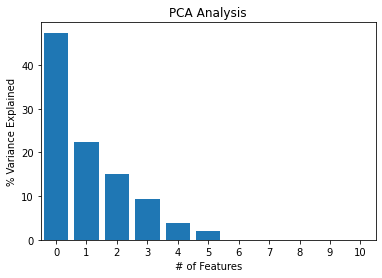

In [39]:
n_components = len(hexaco_df.columns)
hexaco_pca = PCA(n_components=n_components)
hexaco_principal_components = hexaco_pca.fit_transform(hexaco_df)
variance = hexaco_pca.explained_variance_ratio_
hexaco_var = np.round(hexaco_pca.explained_variance_ratio_, decimals=3)*100
hexaco_var
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.xlim(-.5,10.5)
plt.xticks(range(0, 11))
plt.style.context('seaborn-whitegrid')
plt.bar(x=range(0, n_components), height=hexaco_var)

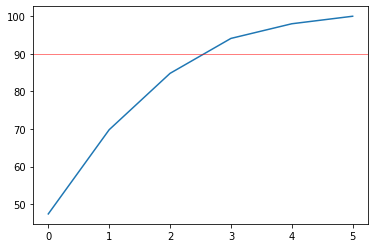

In [40]:
plt.plot(range(0,len(hexaco_var)), np.cumsum(hexaco_var))
plt.gca().axhline(y=90, color='red', linewidth=.5)

In [41]:
hexaco_pca_df = pd.DataFrame(hexaco_principal_components, index=hexaco_df.index)
hexaco_pca_df['name'] = hexaco_pca_df.index.map(names_df['character'].to_dict())
hexaco_pca_df['work'] = hexaco_pca_df.index.map(names_df['work'].to_dict())
hexaco_pca_df.head(3)

,0,1,2,3,4,5,name,work
NCIS/1,287.104452,-155.717114,-5.917869,-9.686579,74.090815,-48.631797,Leroy Jethro Gibbs,NCIS
NCIS/2,-199.148759,-19.947211,-204.073452,10.503652,23.526925,14.270827,Anthony DiNozzo,NCIS
NCIS/3,-432.698839,-144.101716,25.428423,14.529359,-22.051934,-25.542102,Abby Sciuto,NCIS


In [42]:
px.scatter_3d(hexaco_pca_df, x=0, y=1, z=2)

In [43]:
n_neighbors = 5
a=3.5
b=.5
metric='correlation'

# for metric in ['correlation', 'cosine', 'euclidean']:
#     for a in [.5, 1.5, 2.5]:
#         for b in np.arange(.35, .55, .08):
#             for n_neighbors in range(16, 17, 8):
trans = umap.UMAP(n_neighbors=n_neighbors, a=a, b=b, random_state=0, n_components=3, metric=metric).fit_transform(hexaco_pca_df.iloc[:,:-2])
umap_df = pd.DataFrame(trans, index=names_df.index)
umap_df['name'] = umap_df.index.map(names_df['character'].to_dict())
umap_df['work'] = umap_df.index.map(names_df['work'].to_dict())
print(n_neighbors, a, b, metric)
px.scatter_3d(umap_df, x=0, y=1, z=2, hover_name='name', hover_data=['name', 'work']).show()
px.scatter_3d(umap_df.loc[known_chars], x=0, y=1, z=2, hover_name='name', hover_data=['name', 'work']).show()

5 3.5 0.5 correlation


## Binning

Place scores in 20% bins, i.e. in A v. B

| Score  | Name       | Bin |
|--------|------------|-----|
| 0-20   | Strongly A | 0   |
| 20-40  | Weakly A   | 1   |
| 40-60  | Medium     | 2   |
| 60-80  | Weakly B   | 3   |
| 80-100 | Strongly B | 4   |

In [44]:
# The means of the ratings of each character for each trait
bin_df = pd.read_csv('data/op/character_means.csv', index_col=0)
# The standard deviations of the *ratings* before aggregation
# std_df = pd.read_csv('data/op/character_std.csv', index_col=0)
# # The number of observations for each trait for each character
# n_df = pd.read_csv('data/op/character_n.csv', index_col=0)
bin_df = raw_df.applymap(lambda x: (x // 20)-2)
bin_df.head(3)

,BAP3,BAP4,BAP5,BAP11,BAP12,BAP16,BAP18,BAP19,BAP20,BAP21,BAP23,BAP30,BAP34,BAP35,BAP40,BAP43,BAP46,BAP49,BAP52,BAP54,BAP60,BAP61,BAP62,BAP65,BAP66,BAP69,BAP70,BAP74,BAP79,BAP80,BAP85,BAP86,BAP87,BAP88,BAP89,BAP91,BAP93,BAP99,BAP100,BAP101,...,BAP162,BAP163,BAP164,BAP165,BAP167,BAP168,BAP169,BAP170,BAP171,BAP172,BAP173,BAP174,BAP175,BAP176,BAP177,BAP178,BAP181,BAP185,BAP187,BAP190,BAP192,BAP193,BAP194,BAP196,BAP198,BAP203,BAP204,BAP206,BAP209,BAP212,BAP216,BAP217,BAP218,BAP220,BAP221,BAP225,BAP226,BAP230,BAP232,BAP233
NCIS/1,1.0,-2.0,-1.0,2.0,1.0,0.0,-1.0,-1.0,2.0,0.0,-2.0,0.0,2.0,2.0,-1.0,0.0,-1.0,-1.0,-1.0,2.0,-1.0,0.0,-2.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-2.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,-1.0,-2.0,0.0,0.0,-1.0,1.0,1.0,1.0,0.0,-2.0,2.0,2.0,-2.0,2.0,0.0,0.0,-2.0,0.0,2.0,0.0,-2.0,1.0,1.0,-1.0,-1.0,-1.0,-2.0,1.0,1.0,2.0,1.0,0.0,-2.0,-2.0,-1.0,-2.0,-1.0,-2.0,-1.0,-2.0
NCIS/2,-1.0,-2.0,-2.0,1.0,0.0,0.0,1.0,-2.0,1.0,0.0,1.0,-1.0,-2.0,0.0,-1.0,0.0,-1.0,2.0,-1.0,0.0,2.0,0.0,-2.0,-1.0,1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-2.0,-2.0,1.0,1.0,-1.0,-1.0,...,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,-1.0,0.0,-1.0,0.0,-2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,-2.0,0.0,-2.0,-2.0,0.0,1.0,-2.0,-1.0,0.0,0.0,1.0,-1.0,0.0,1.0
NCIS/3,-2.0,1.0,-1.0,0.0,1.0,2.0,0.0,-1.0,-1.0,1.0,1.0,-2.0,-2.0,0.0,-2.0,1.0,0.0,2.0,0.0,-1.0,2.0,0.0,-1.0,-2.0,0.0,0.0,-2.0,1.0,2.0,0.0,0.0,-2.0,0.0,2.0,-2.0,0.0,-2.0,2.0,-1.0,0.0,...,-1.0,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0,-2.0,-1.0,-1.0,2.0,1.0,0.0,1.0,0.0,-2.0,1.0,-1.0,1.0,1.0,2.0,-1.0,-1.0,2.0,0.0,-2.0,0.0,-1.0,-1.0,-2.0,-1.0,-2.0,-1.0,-1.0,-1.0,-2.0,-1.0,-2.0,1.0


<BarContainer object of 112 artists>

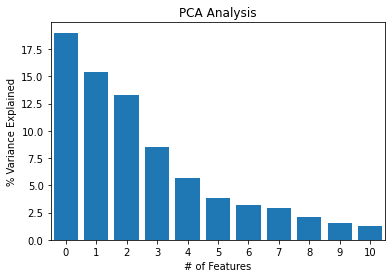

In [45]:
n_components = len(bin_df.columns)
bin_pca = PCA(n_components=n_components)
bin_principal_components = bin_pca.fit_transform(bin_df)
variance = bin_pca.explained_variance_ratio_
bin_var = np.round(bin_pca.explained_variance_ratio_, decimals=3)*100
bin_var
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.xlim(-.5,10.5)
plt.xticks(range(0, 11))
plt.style.context('seaborn-whitegrid')
plt.bar(x=range(0, n_components), height=bin_var)

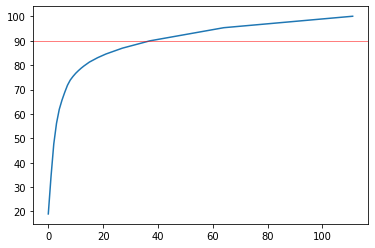

In [46]:
plt.plot(range(0,len(bin_var)), np.cumsum(bin_var))
plt.gca().axhline(y=90, color='red', linewidth=.5)

In [47]:
cum_var = np.cumsum(bin_var)
sufficient_explained = 3
for i in range(len(cum_var)):
    if cum_var[i] >= 90:
        sufficient_explained = i
        break
sufficient_explained

38

In [48]:
bin_pca_df = pd.DataFrame(bin_principal_components, index=bin_df.index)
bin_pca_df['name'] = bin_pca_df.index.map(names_df['character'].to_dict())
bin_pca_df['work'] = bin_pca_df.index.map(names_df['work'].to_dict())
bin_pca_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,name,work
NCIS/1,-8.543769,-2.270186,1.549546,4.608987,-1.923921,0.298207,-0.331865,-0.838040,1.109788,1.088910,-0.915380,-0.889280,0.989482,0.566375,-0.299257,0.277226,-1.048992,0.246029,0.130902,-0.375391,0.019190,-0.309834,0.802592,0.515733,-0.781368,0.091096,0.940989,-0.568009,0.008280,0.192815,0.400787,-0.189157,0.006919,0.268452,-0.741665,0.113837,-0.349966,0.399825,0.000899,-0.245579,...,0.425860,1.088046,0.006970,0.604654,-0.473115,0.260443,0.329931,0.005656,-0.337329,-0.385078,-0.101691,-0.288464,-0.099748,0.267461,0.136143,0.179396,-0.001755,-0.638324,-0.135154,-0.566488,-0.294442,0.453097,-0.178088,0.148767,0.070088,0.277694,-0.306989,0.159814,0.289904,-0.442012,0.314709,0.106726,-0.127926,0.640367,0.131699,-0.055775,-0.487816,-0.106704,Leroy Jethro Gibbs,NCIS
NCIS/2,3.480100,-3.967601,-3.274755,-1.503971,-4.239764,0.068161,-0.938452,2.314560,-1.826993,-1.162490,-1.065163,0.211357,0.161034,1.570779,0.207653,-0.474813,-1.260064,-0.703309,-1.078549,-0.445947,0.148516,0.289677,-0.316900,1.439487,0.427418,0.831868,0.389680,-0.495688,0.076769,0.720120,1.013250,0.304324,-0.570928,0.210782,0.422098,-0.517860,-0.054653,0.145569,-0.270263,-0.386473,...,-0.292918,0.039182,0.050736,-0.156186,0.157459,0.488957,0.059955,0.127441,0.067969,-0.360382,-0.907522,-0.292574,-0.502891,0.181204,0.068442,-0.373806,-0.426220,-0.008312,0.295593,0.241693,-0.471396,-0.314725,-0.008826,0.412603,-0.036662,0.284946,0.048038,0.387694,0.007973,-0.334777,-0.064288,0.356404,0.051181,-0.264479,-0.575675,-0.558876,-0.068307,-0.014880,Anthony DiNozzo,NCIS
NCIS/3,1.241155,-4.287272,-7.498035,-1.940072,4.336276,-0.028387,4.296439,1.963332,-0.727558,-0.023861,0.558438,0.853474,1.666423,-0.441779,0.401374,-0.155626,-0.034544,-1.964132,0.228717,1.072910,-0.339069,-0.641812,-0.275744,-0.162131,-0.183371,-0.731844,0.859303,0.021563,-0.384443,-0.719385,0.585111,0.030895,-0.436137,-0.411972,-1.347877,0.242683,0.694713,-1.402778,-1.035107,0.486074,...,0.991091,0.507063,0.407846,0.070362,-0.091486,-0.140992,-0.089859,0.126111,-0.420217,-0.242975,-0.412107,-0.274506,-0.028947,0.066990,0.055880,-0.050933,0.238612,-0.405758,0.292442,-0.202653,0.006191,-0.461859,0.259171,-0.251718,0.465768,-0.501455,-0.318255,0.500388,-0.181569,0.596016,-0.260734,0.098622,0.541196,0.483225,-0.343109,-0.107325,0.163626,-0.021682,Abby Sciuto,NCIS


In [49]:
px.scatter_3d(bin_pca_df, x=0, y=1, z=2)

In [50]:
n_neighbors = 5
a=3.5
b=.5
metric='correlation'

# for metric in ['correlation', 'cosine', 'euclidean']:
#     for a in [.5, 1.5, 2.5]:
#         for b in np.arange(.35, .55, .08):
#             for n_neighbors in range(16, 17, 8):
trans = umap.UMAP(n_neighbors=n_neighbors, a=a, b=b, random_state=0, n_components=3, metric=metric).fit_transform(bin_pca_df.iloc[:,:sufficient_explained])
umap_df = pd.DataFrame(trans, index=names_df.index)
umap_df['name'] = umap_df.index.map(names_df['character'].to_dict())
umap_df['work'] = umap_df.index.map(names_df['work'].to_dict())
print(n_neighbors, a, b, metric)
px.scatter_3d(umap_df, x=0, y=1, z=2, hover_name='name', hover_data=['name', 'work']).show()
px.scatter_3d(umap_df.loc[known_chars], x=0, y=1, z=2, hover_name='name', hover_data=['name', 'work']).show()

5 3.5 0.5 correlation


## Composite traits

In [51]:
transpose_df = pd.read_csv('data/op/character_means.csv', index_col=0)
transpose_df = transpose_df.transpose()
transpose_df.drop(emoji_cols, inplace=True)
transpose_df.drop('BAP183', inplace=True)
transpose_df.drop('BAP68', inplace=True)
transpose_df.head(3)

,NCIS/1,NCIS/2,NCIS/3,NCIS/4,NCIS/5,NCIS/6,WD/1,WD/2,WD/3,WD/4,WD/5,WD/6,WD/7,WD/8,WD/9,WD/10,BB/1,BB/2,BB/3,BB/4,BB/5,BB/6,BB/7,BB/8,BB/9,BB/10,WO/1,WO/2,WO/3,WO/4,WO/5,WO/6,TIU/1,TIU/2,TIU/3,TIU/4,TIU/5,TIU/6,TIU/7,TIU/8,...,GOT/22,GOT/23,GOT/24,GOT/25,GOT/26,GOT/27,GOT/28,GOT/29,GOT/30,I/1,I/2,I/3,I/4,I/5,I/6,LOTR/1,LOTR/2,LOTR/3,LOTR/4,LOTR/5,LOTR/6,LOTR/7,LOTR/8,LOTR/9,LOTR/10,MCU/1,MCU/2,MCU/3,MCU/4,MCU/5,MCU/6,MCU/7,MCU/8,MCU/9,MCU/10,MCU/11,MCU/12,MCU/13,MCU/14,MCU/15
BAP1,86.5,18.5,16.0,63.5,68.6,38.2,87.1,77.1,72.1,71.5,66.2,50.3,68.3,80.0,82.6,52.4,88.0,82.1,41.4,67.0,64.6,47.0,35.3,93.3,93.4,40.8,46.5,54.6,19.4,49.3,44.3,78.0,39.0,49.9,69.0,66.8,28.2,56.9,20.7,34.7,...,91.8,63.8,85.4,52.2,41.4,77.7,32.3,31.1,70.8,82.3,56.2,65.9,67.4,82.7,82.1,66.8,80.6,75.0,15.3,61.4,63.6,56.7,73.5,17.4,54.2,30.9,79.4,72.1,63.7,73.1,37.2,87.1,81.6,77.9,81.9,92.7,75.2,26.1,50.4,10.8
BAP2,82.1,88.2,86.3,64.7,32.4,29.1,88.5,93.1,65.6,78.1,62.1,56.5,64.5,70.2,75.7,92.3,82.2,73.1,75.1,89.0,71.7,40.6,81.8,83.9,83.4,76.8,62.3,49.1,52.2,38.4,23.7,89.5,82.3,74.4,65.6,50.2,81.8,88.2,80.1,58.0,...,74.6,86.9,92.1,92.8,92.7,94.6,80.3,92.5,90.1,80.8,56.6,57.3,83.0,80.3,55.9,52.5,82.1,88.4,76.0,51.7,89.1,88.1,79.2,66.3,55.5,94.4,76.0,87.5,28.8,88.5,92.2,91.4,81.1,83.3,86.0,94.8,83.9,87.4,69.8,89.0
BAP3,74.8,24.3,11.9,29.1,42.1,25.7,77.9,77.4,70.4,72.0,50.2,40.8,68.4,80.3,76.0,69.1,81.9,75.8,75.2,49.8,55.7,52.1,45.6,72.7,83.1,76.9,32.3,58.1,39.3,62.5,75.9,75.4,38.2,32.5,57.1,65.6,52.4,31.3,31.2,49.8,...,87.9,67.8,82.4,43.7,53.9,78.8,51.3,45.0,70.4,85.9,45.5,55.0,84.7,70.7,78.5,62.2,72.2,71.8,13.3,30.6,53.7,45.3,56.6,21.7,87.6,54.7,52.7,72.0,66.7,56.4,39.0,73.8,72.7,63.3,75.4,86.7,47.4,63.8,56.2,21.7


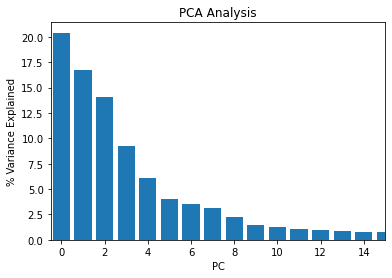

In [52]:
pca = PCA(n_components = min(len(transpose_df.columns), len(transpose_df.index)))
principal_components = pca.fit_transform(transpose_df)
transpose_var = pca.explained_variance_ratio_
transpose_var = np.round(pca.explained_variance_ratio_, decimals=3)*100
plt.ylabel('% Variance Explained')
plt.xlabel('PC')
plt.title('PCA Analysis')
plt.xlim(-.5,15)
plt.style.context('seaborn-whitegrid')
plt.bar(x=range(0, len(var)), height=var)
pca_df = pd.DataFrame(principal_components, index=transpose_df.index)

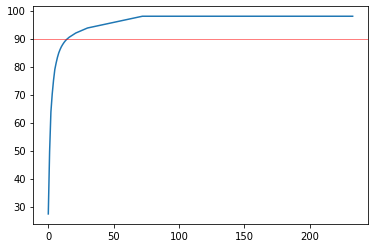

In [53]:
plt.plot(range(0,len(transpose_var)), np.cumsum(transpose_var))
plt.gca().axhline(y=90, color='red', linewidth=.5)

In [54]:
cum_var = np.cumsum(transpose_var)
sufficient_explained = 3
for i in range(len(cum_var)):
    if cum_var[i] >= 90:
        sufficient_explained = i
        break
sufficient_explained

15

In [55]:
transpose_pca_df = pd.DataFrame(principal_components, index=transpose_df.index)
transpose_pca_df['Trait'] = trait_df['adjectives']
transpose_pca_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,Trait
BAP1,-459.009999,-133.563183,419.116825,-62.131397,-112.999335,-61.512917,-93.647590,-109.334017,33.480190,-29.452235,-0.781386,-23.625036,-26.846465,57.739117,-28.765389,32.249583,-7.626366,-22.396883,28.299050,-1.195367,-16.345471,7.838611,-12.100948,-5.670003,1.400741,1.220034,6.796876,52.573305,-43.026733,-1.776049,-23.319080,-20.447421,6.727177,-42.791691,-22.571066,4.182482,17.573011,23.638669,-8.284048,13.19571,...,10.925707,10.321465,-7.958003,2.293901,-5.018789,5.012585,-1.479500,10.828041,7.101162,-3.515799,-3.613538,-6.130663,0.846782,-0.310567,-0.898148,5.138694,-1.310670,-6.997854,9.678397,1.328748,-5.272663,-9.790867,-4.898118,4.577712,-0.173176,-0.010427,5.199675,3.076982,-8.364737,-5.188477,0.599103,-11.759153,-1.992416,3.508697,6.249220,-0.354350,1.064115,-9.914251,5.190170e-13,"[playful, serious]"
BAP2,-414.347043,-582.932418,-305.572202,69.507306,-113.832642,133.952234,102.566246,-16.221235,-58.251075,-6.599680,2.993337,17.693931,-24.259204,109.561882,-16.899650,5.913036,-11.719631,-37.027934,6.073956,-62.227891,-9.388256,2.923012,3.621622,18.530114,48.060053,-3.134744,16.949024,4.318100,7.913513,-0.439272,-19.953769,7.945259,26.634301,-26.800451,-39.755785,-21.940244,-0.168866,37.133683,3.849988,17.96807,...,-6.191224,2.746530,-9.644691,-10.433374,6.549801,1.940623,1.588092,0.560450,2.375399,4.904974,0.603793,3.442850,-5.763313,-4.000048,-9.344762,0.150094,15.821424,-6.843030,-5.700842,-5.743021,4.455546,3.019582,3.180705,1.622937,-15.414795,-0.620985,-11.942677,-10.264567,-8.764618,-7.952746,2.920114,-3.051116,-2.321858,-0.262294,-6.497450,-8.257146,-2.946576,8.277607,5.190170e-13,"[shy, bold]"
BAP3,-165.655494,-271.569620,285.599138,-143.582266,-112.922578,-179.324993,-200.148170,-106.199551,-68.596418,28.067075,-62.193219,-81.463517,-2.335322,54.590445,-27.776019,0.741903,27.384916,-0.108805,4.368051,-45.920727,-26.597527,-15.543501,20.493323,1.291563,21.731286,-12.564921,22.970334,-26.972620,-20.955901,19.267991,-7.739197,-6.793571,13.431033,-11.646749,-4.926429,30.404194,4.557035,-1.553087,-19.929525,-8.86080,...,5.771115,5.226989,1.863223,14.661865,1.674406,-3.769974,4.852726,-3.357802,-5.064294,4.540945,-0.699761,0.259062,-6.361419,-6.351060,13.660281,-6.054697,-1.696411,-3.443268,-7.060608,4.356435,-4.224535,-2.480548,-2.479601,-7.206017,4.300802,5.222966,-3.735899,2.443579,3.800314,6.027418,4.139717,0.469323,-2.069653,-8.578844,1.969411,-3.221893,-11.304292,17.825595,5.190170e-13,"[cheery, sorrowful]"


In [56]:
px.scatter_3d(transpose_pca_df, x=0, y=1, z=2)

In [57]:
trans = umap.UMAP(n_components=3, n_neighbors=5, metric='correlation', a=1, b=.5).fit_transform(transpose_pca_df.iloc[:,:sufficient_explained])
umap_df = pd.DataFrame(trans, index=transpose_pca_df.index)
umap_df.index = umap_df.index.map(trait_dict)

px.scatter_3d(umap_df, x=0, y=1, z=2, hover_name=umap_df.index)

## Clustering (NOT READY)

In [58]:
# from sklearn.cluster import AgglomerativeClustering

# traits_to_cluster = {'H':0, 'E':1, 'X':2, 'A':3, 'C':4, 'O':5, 'OTHER':6}
# def apply_dict(row):
#     return traits_to_cluster[trait_df.loc[row.name,'Hexaco']]

# # transpose_df['cluster'] = AgglomerativeClustering(n_clusters=6).fit(transpose_df).labels_
# # transpose_df['trait'] = transpose_df.index.map(trait_dict)
# # transpose_df['hand cluster'] = transpose_df.apply(apply_dict, axis=1)
# # transpose_df.sort_values('cluster').iloc[0:50,:]

# # from yellowbrick.cluster import KElbowVisualizer

# # model = KMeans()
# # visualizer = KElbowVisualizer(model, k=(2,150))
# # visualizer.fit(raw_df)
# # visualizer.show()

# Even after reducing the dimensions to our bin personality labels and performing PCA, we see little clustering structure in the data.

# import seaborn as sns

# sns.heatmap(hexaco_df.corr(), annot=True)

# px.scatter_matrix(hexaco_df)

# px.scatter(hexaco_df, x='H', y='E')

# # kmeans = KMeans(n_clusters=41, random_state=0).fit(raw_df)

# # df = pd.DataFrame(principalComponents)
# # df[range(0,50)]



# def sum_squares(row):
#     coords = []
#     for col in row.index:
#         if col[0:3] == 'BAP':
#             coords.append(float(row[col]))
#     dist = coords - kmeans.cluster_centers_[row['cluster']]
#     return np.dot(dist.T, dist)

# raw_df['sum_sq'] = raw_df.apply(sum_squares, axis=1)

# sorted_clusters = raw_df.groupby('cluster').agg(np.mean)['sum_sq'].sort_values()


# raw_df[raw_df['cluster'] == sorted_clusters.index[0]][['name', 'show']]

# raw_df[raw_df['cluster'] == sorted_clusters.index[1]][['name', 'show']]

# raw_df.corr().loc['BAP194'].sort_values()

# original_df.shape

# original_df



# tsne = TSNE(n_components=3, perplexity=5).fit_transform(raw_df)

# tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2', 'tsne3'], index=names)
# tsne_df['name'] = tsne_df.index

# plotly.offline.init_notebook_mode()
# px.scatter_3d(tsne_df, x='tsne1', y='tsne2', z='tsne3', hover_name='name')

# df = pd.DataFrame(principalComponents)
# df = df[range(0,50)]

# df

# names



# early_exaggeration=1.2
# perplexity = 1.5
# learning_rate = 77
# tsne = TSNE(n_components=3, perplexity=perplexity, learning_rate=learning_rate, random_state=0, early_exaggeration=early_exaggeration, method='exact').fit_transform(original_df)
# tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2', 'tsne3'], index=names)
# tsne_df['name'] = tsne_df.index
# kmeans = KMeans(n_clusters=28).fit(original_df)
# tsne_df['cluster'] = kmeans.labels_
# print('exaggeration', early_exaggeration, 'perplexity', perplexity, 'learning', learning_rate)
# px.scatter_3d(tsne_df, x='tsne1', y='tsne2', z='tsne3', hover_name='name').show()

# px.scatter_3d(tsne_df, x='tsne1', y='tsne2', z='tsne3', hover_name='name', color='cluster').show()

# early_exaggeration=8
# perplexity = 13
# learning_rate = 77
# tsne = TSNE(n_components=3, perplexity=perplexity, learning_rate=learning_rate, random_state=0, early_exaggeration=early_exaggeration, method='exact').fit_transform(raw_df[big_five])
# tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2', 'tsne3'], index=names)
# tsne_df['name'] = tsne_df.index
# kmeans = KMeans(n_clusters=28).fit(original_df)
# tsne_df['cluster'] = kmeans.labels_
# print('exaggeration', early_exaggeration, 'perplexity', perplexity, 'learning', learning_rate)
# px.scatter_3d(tsne_df, x='tsne1', y='tsne2', z='tsne3', hover_name='name').show()

# trans = umap.UMAP(n_neighbors=5, min_dist=0, random_state=0, n_components=3).fit_transform(hexaco_df)
# umap_df = pd.DataFrame(trans, index=names_df.index)
# umap_df['name'] = umap_df.index.map(names_df['character'].to_dict())
# umap_df['work'] = umap_df.index.map(names_df['work'].to_dict())
# px.scatter_3d(umap_df, x=0, y=1, z=2, hover_name='name', hover_data=['name', 'work'])













# early_exaggeration=2
# perplexity = 5
# learning_rate = 72
# tsne = TSNE(n_components=3, perplexity=perplexity, learning_rate=learning_rate, random_state=0, early_exaggeration=early_exaggeration, method='exact').fit_transform(raw_df[['pca1', 'pca2', 'pca3', 'pca4', 'pca5']])
# tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2', 'tsne3'], index=names)
# tsne_df['name'] = tsne_df.index
# kmeans = KMeans(n_clusters=28).fit(raw_df[hexaco])
# tsne_df['cluster'] = kmeans.labels_
# print('exaggeration', early_exaggeration, 'perplexity', perplexity, 'learning', learning_rate)
# px.scatter_3d(tsne_df, x='tsne1', y='tsne2', z='tsne3', hover_name='name').show()

# raw_df = raw_df.applymap(lambda x: (x // 20)-2)

# TO DO:  
#### Clustering
- [ ] Cluster from UMAP  
- [ ] Hierarchical clustering  
- [ ] Finish labeling, try supervised learning  

#### Read about personality and behavior
- [ ] 